### Imports

In [ ]:
from google.colab import drive

import random
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# Visualization
import matplotlib
import graphviz # for showing model diagram
import plotly
import plotly.express as px # for data visualization

# Other utilities
import sys
import os
import zipfile

# Assign main directory to a variable
# main_dir=os.path.dirname(sys.path[0])
SEED=49

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


### Tableau Bookshop Dataset
https://help.tableau.com/current/pro/desktop/en-us/bookshop_data.htm

In [ ]:
# Loading Data
xls_file = pd.ExcelFile('/content/drive/MyDrive/term_4/sw_prj/Bookshop.xlsx')
df_ratings = pd.read_excel(xls_file, 'Ratings')
df_ratings

,BookID,Rating,ReviewerID,ReviewID
0,AD222,5,105,3372
1,AD222,3,113,7340
2,AD222,3,234,20430
3,AD222,4,459,40653
4,AD222,2,550,51337
...,...,...,...,...
50325,ZT703,2,53119,5308138
50326,ZT703,5,53141,5310932
50327,ZT703,3,53176,5312650
50328,ZT703,4,53354,5327579


In [ ]:
# INITIAL EXPLORATION

# Finding duplicates
duplicates = df_ratings.duplicated(subset=['ReviewID'])
print("Duplicate rows by 'ReviewID'")
duplicates.value_counts()

Duplicate rows by 'ReviewID'


False    50330
dtype: int64

In [ ]:
duplicates = df_ratings.duplicated(subset=['BookID', 'Rating', 'ReviewerID'])

print("Duplicate rows by 'BookID', 'Rating', and 'ReviewerID'")
duplicates.value_counts()

Duplicate rows by 'BookID', 'Rating', and 'ReviewerID'


False    50330
dtype: int64

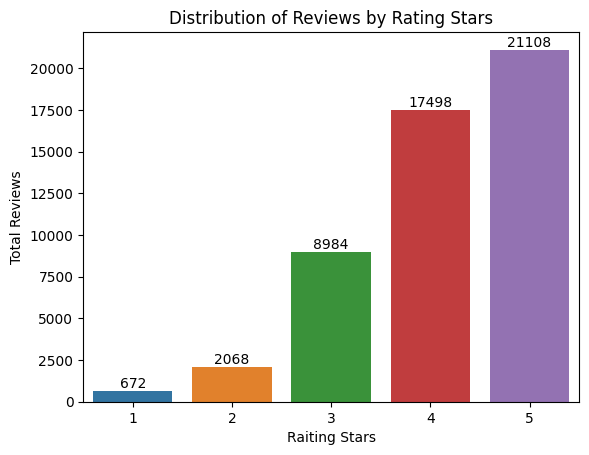

In [ ]:
rate_dist_plt = sns.countplot(x='Rating', data=df_ratings)
for p in rate_dist_plt.patches:
    counts = int(p.get_height())
    if (counts > 0):
      rate_dist_plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.title('Distribution of Reviews by Rating Stars')
plt.xlabel('Raiting Stars')
plt.ylabel('Total Reviews')
plt.show()

In [ ]:
df_ratings = df_ratings[df_ratings['Rating'] > 3] #we do this to increase the vector size to 6
df_ratings

,BookID,Rating,ReviewerID,ReviewID
0,AD222,5,105,3372
3,AD222,4,459,40653
5,AD222,4,613,52687
7,AD222,4,1014,98430
9,AD222,4,1307,126839
...,...,...,...,...
50322,ZT703,4,53100,5301387
50323,ZT703,5,53108,5303870
50324,ZT703,5,53113,5302489
50326,ZT703,5,53141,5310932


In [ ]:
# Number of reviewers
num_reviewers = len(df_ratings['ReviewerID'].unique())
print("Number of Reviewers:", num_reviewers)

Number of Reviewers: 25901


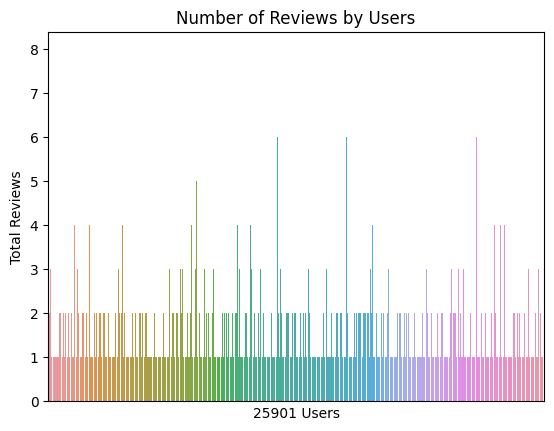

In [ ]:
review_counts = df_ratings['ReviewerID'].value_counts()
prod_dist_plt = sns.barplot(x=review_counts.index, y=review_counts.values)

plt.title('Number of Reviews by Users')
plt.xlabel(f'{len(review_counts)} Users')
plt.ylabel('Total Reviews')
plt.xticks([])
plt.show()

In [ ]:
num_users_with_n_reviews_m_stars = review_counts.loc[lambda x: x > 3] # users who has 4 or more reviws
len(num_users_with_n_reviews_m_stars)

737

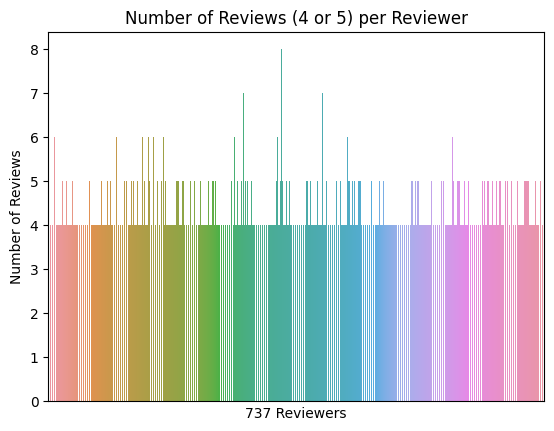

In [ ]:
ax = sns.barplot(x=num_users_with_n_reviews_m_stars.index, y=num_users_with_n_reviews_m_stars.values)

plt.xlabel(f'{len(num_users_with_n_reviews_m_stars)} Reviewers')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews (4 or 5) per Reviewer')
plt.xticks([])
plt.show()

In [ ]:
# Getting number of samples that resulted from filtering out users with 4 or more reviews who gave 4 or 5 stars (Good and Excellent = like)
reviewer_ids = num_users_with_n_reviews_m_stars.index
is_selected_id = df_ratings['ReviewerID'].isin(reviewer_ids)
rating_cap = df_ratings['Rating'] > 3

df_ratings_tableau = df_ratings[is_selected_id & rating_cap]

###Book Crossing

####Dataset Loading

In [ ]:
# https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset/data
origin_path = '/content/drive/MyDrive/term_4/sw_prj/book_crossing.zip'
extract_path = '/content/book_crossing'
target_filename = 'Preprocessed_data.csv'

with zipfile.ZipFile(origin_path, 'r') as zip_ref:
    zip_ref.extractall('/content/book_crossing')

In [ ]:
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file == target_filename:
            file_path = os.path.join(root, file)
            bc_df = pd.read_csv(file_path)
bc_df.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


#### Exploratory Analysis

In [ ]:
bc_df.shape

(1031175, 19)

In [ ]:
bc_df.columns
# BookID 	Rating 	ReviewerID 	ReviewID

Index(['Unnamed: 0', 'user_id', 'location', 'age', 'isbn', 'rating',
       'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city',
       'state', 'country'],
      dtype='object')

In [ ]:
df_ratings = bc_df[['isbn', 'rating', 'user_id', 'Unnamed: 0']].rename(columns={'user_id': 'ReviewerID', 'rating': 'Rating', 'isbn': 'BookID', 'Unnamed: 0': 'ReviewID'})
df_ratings

,BookID,Rating,ReviewerID,ReviewID
0,0195153448,0,2,0
1,0002005018,5,8,1
2,0002005018,0,11400,2
3,0002005018,8,11676,3
4,0002005018,0,41385,4
...,...,...,...,...
1031170,0743203763,0,278851,1031170
1031171,0767907566,5,278851,1031171
1031172,0884159221,7,278851,1031172
1031173,0912333022,7,278851,1031173


In [ ]:
num_reviews = df_ratings.shape[0]
num_users=len(df_ratings['ReviewerID'].unique())
num_products=len(df_ratings['BookID'].unique())
avg_review_x_product=num_reviews/num_products
avg_review_x_user=num_reviews/num_users

print("Total reviews:", num_reviews)
print("Unique Users:", num_users)
print("Unique Books:", num_products)

Total reviews: 1031175
Unique Users: 92107
Unique Books: 270170


In [ ]:
# Finding duplicates
duplicates = df_ratings.duplicated(subset=['ReviewID'])
print("Duplicate rows by 'ReviewID'")
duplicates.value_counts()

Duplicate rows by 'ReviewID'


False    1031175
dtype: int64

In [ ]:
duplicates = df_ratings.duplicated(subset=['BookID', 'Rating', 'ReviewerID'])

print("Duplicate rows by 'BookID', 'Rating', and 'ReviewerID'")
duplicates.value_counts()

Duplicate rows by 'BookID', 'Rating', and 'ReviewerID'


False    1031175
dtype: int64

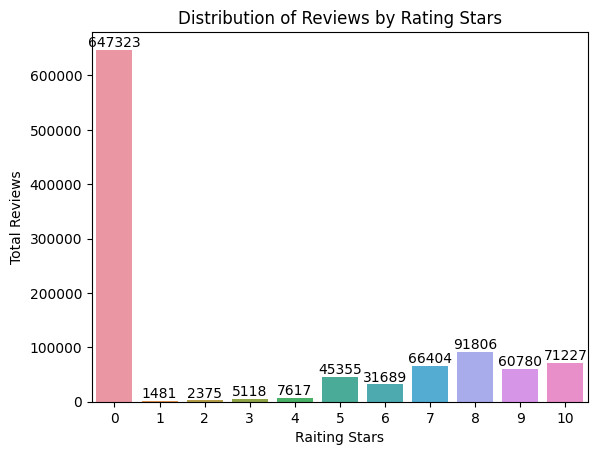

In [ ]:
rate_dist_plt = sns.countplot(x='Rating', data=df_ratings)
for p in rate_dist_plt.patches:
    counts = int(p.get_height())
    if (counts > 0):
      rate_dist_plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.title('Distribution of Reviews by Rating Stars')
plt.xlabel('Raiting Stars')
plt.ylabel('Total Reviews')
plt.show()

####Preprocessing

In [ ]:
# keep rate reviews of 8 to 10 stars (defined as good, positive preference)
df_ratings_filtered = df_ratings[df_ratings['Rating'] >= 8]
df_ratings_filtered.shape

(223813, 4)

In [ ]:
# book_counts = df_ratings_filtered['BookID'].value_counts()
# book_ids_to_keep = book_counts[book_counts >= min_reviews_per_reviewer].index
min_reviews_per_reviewer = 10

review_counts = df_ratings_filtered['BookID'].value_counts()
sorted_df = review_counts.sort_values(ascending=False)

top_book_ids = sorted_df[:600].index.to_list()
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered['BookID'].isin(top_book_ids)]
df_ratings_filtered

reviewer_counts = df_ratings_filtered['ReviewerID'].value_counts()
reviewer_ids_to_keep = reviewer_counts[reviewer_counts >= min_reviews_per_reviewer].index
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered['ReviewerID'].isin(reviewer_ids_to_keep)]

In [ ]:
num_reviews = df_ratings_filtered.shape[0]
num_users=len(df_ratings_filtered['ReviewerID'].unique())
num_products=len(df_ratings_filtered['BookID'].unique())

print("Total reviews:", num_reviews)
print("Unique Users:", num_users)
print("Unique Books:", num_products)

Total reviews: 8399
Unique Users: 500
Unique Books: 600


In [ ]:
# Verifying that at least there are 7 reviews by reviewer
review_counts = df_ratings_filtered.groupby('ReviewerID').size()
print("min number of reviews per user:", np.min(review_counts.values))
print("max number of reviews per user:", np.max(review_counts.values))

min number of reviews per user: 10
max number of reviews per user: 249


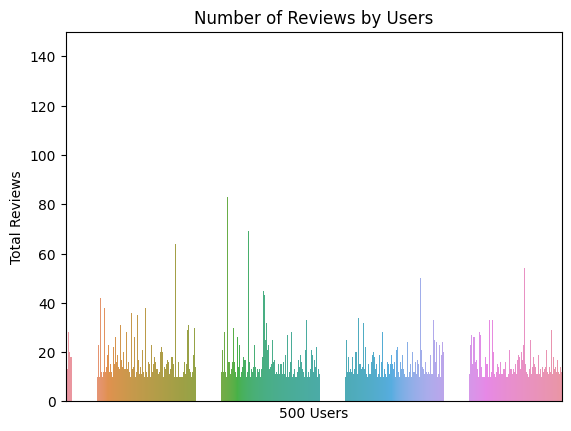

In [ ]:
prod_dist_plt = sns.barplot(x=review_counts.index, y=review_counts.values)

plt.title('Number of Reviews by Users')
plt.xlabel(f'{len(review_counts)} Users')
plt.ylabel('Total Reviews')
plt.ylim(0,150)
plt.xticks([])
plt.show()

In [ ]:
df_ratings_crossing = df_ratings_filtered.copy()
df_ratings_crossing.drop(['Rating'], axis=1, inplace=True)
df_ratings_crossing.head(10)

,BookID,ReviewerID,ReviewID
106,0440234743,7346,106
112,0440234743,11676,112
115,0440234743,13552,115
128,0440234743,23511,128
140,0440234743,31315,140
253,0440234743,107784,253
276,0440234743,122440,276
284,0440234743,124487,284
286,0440234743,125519,286
299,0440234743,133706,299


In [ ]:
df_ratings_crossing.shape

(8399, 3)

In [ ]:
# Saving clean and prepocessed dataset
df_ratings_crossing.to_csv('/content/drive/MyDrive/term_4/sw_prj/df_ratings_crossing.csv')

###Click-Vector-Matrix

In [ ]:
df_ratings_crossing = pd.read_csv('/content/drive/MyDrive/term_4/sw_prj/df_ratings_crossing.csv')
df_ratings_crossing = df_ratings_crossing.drop(columns=['Unnamed: 0'])
df_ratings_crossing.head(2)

,BookID,ReviewerID,ReviewID
0,0440234743,7346,106
1,0440234743,11676,112


In [ ]:
cvm_features = len(np.unique(df_ratings_crossing['BookID']))
print(f'vector matrix of {cvm_features} features')

vector matrix of 600 features


In [ ]:
print(f'vector matrix of { len(np.unique(df_ratings_crossing["ReviewerID"])) } samples')

vector matrix of 500 samples


In [ ]:
# click_matrix = df_ratings_crossing.pivot(index='ReviewerID', columns='BookID')
click_matrix = df_ratings_crossing.pivot_table(index='ReviewerID', columns='BookID', fill_value=0, aggfunc='size')
click_matrix

BookID,000649840X,002542730X,0060096195,0060173289,0060175400,0060188731,0060199652,0060391626,0060392452,0060502258,...,1558745718,1559029838,1573225517,1573225789,1573227331,1573229326,1573229571,1592400876,1844262553,1878424319
ReviewerID,,,,,,,,,,,,,,,,,,,,,
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6251,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276050,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
np.unique(click_matrix.nunique(axis=1))

array([2])

In [ ]:
click_matrix.loc[277427].value_counts()

0    588
1     12
Name: 277427, dtype: int64

In [ ]:
click_matrix.shape

(500, 600)

In [ ]:
path="/content/drive/MyDrive/term_4/sw_prj"
os.makedirs(path, exist_ok=True)
click_matrix.to_csv(f'{path}/click-vector-matrix.csv')

### Splitting Data

In [ ]:
X_train, X_test = train_test_split(click_matrix, test_size=0.30, random_state=SEED)

### Variational Autoencoder

####Architecture
Dobilas, S. (2022, May 2). VAE: Variational Autoencoders — How to Employ Neural Networks to Generate New Images. Medium. https://towardsdatascience.com/vae-variational-autoencoders-how-to-employ-neural-networks-to-generate-new-images-bdeb216ed2c0

Bacuet, Q. (2019, April 29). How to implement deep generative models for recommender systems? Snipfeed. https://medium.com/snipfeed/how-to-implement-deep-generative-models-for-recommender-systems-29110be8971f

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

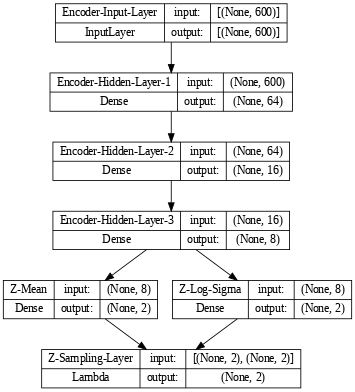

In [ ]:
# Specify dimensions for input/output and latent space layers
original_dim = click_matrix.shape[1] # number of neurons at the input layer (number of books)
latent_dim = 2 # latent space dimension

# ********** Create Encoder **********

#--- Input Layer
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=60)

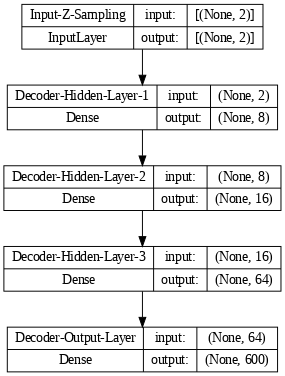

In [ ]:
# ********** Create Decoder **********

#--- Input Layer
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=70)

In [ ]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

In [ ]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Epoch 1/25
22/22 [==============================] - 3s 45ms/step - loss: 136.8339 - val_loss: 113.7365
Epoch 2/25
22/22 [==============================] - 0s 15ms/step - loss: 68.8482 - val_loss: 19625034.0000
Epoch 3/25
22/22 [==============================] - 0s 13ms/step - loss: 32.8624 - val_loss: 11713.4541
Epoch 4/25
22/22 [==============================] - 0s 14ms/step - loss: 22.7235 - val_loss: 548.5339
Epoch 5/25
22/22 [==============================] - 0s 12ms/step - loss: 19.8790 - val_loss: 249.4362
Epoch 6/25
22/22 [==============================] - 0s 14ms/step - loss: 19.1019 - val_loss: 90.1393
Epoch 7/25
22/22 [==============================] - 0s 14ms/step - loss: 18.2564 - val_loss: 36.6694
Epoch 8/25
22/22 [==============================] - 0s 14ms/step - loss: 17.8859 - val_loss: 22.0771
Epoch 9/25
22/22 [==============================] - 1s 28ms/step - loss: 17.3688 - val_loss: 19.3612
Epoch 10/25
22/22 [==============================] - 0s 17ms/step - loss: 17.1

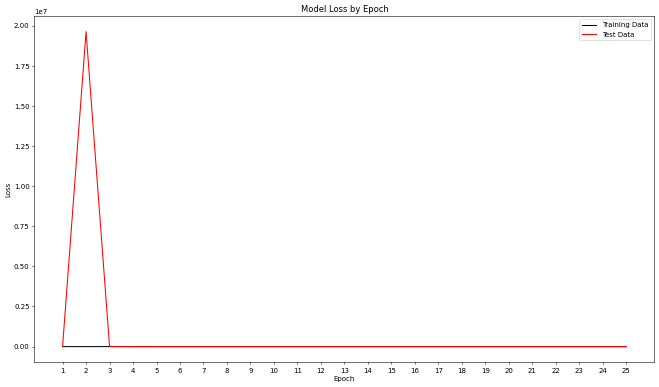

In [ ]:
# Train VAE model
history = vae.fit(X_train, X_train, epochs=25, batch_size=16, validation_data=(X_test, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=50)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

In [ ]:
# Use encoder model to encode inputs into a latent space
X_test_encoded = encoder.predict(X_test)
X_test_encoded

5/5 [==============================] - 0s 3ms/step


[array([[ 0.08820402,  0.06829892],
        [ 0.06809624,  0.0850172 ],
        [ 0.07482582,  0.00682851],
        [-0.02139818,  0.05354988],
        [ 0.05226217,  0.05046436],
        [ 0.03018899,  0.1353707 ],
        [ 0.03467435,  0.02386084],
        [ 0.08690459,  0.01348531],
        [ 0.06509346,  0.00969764],
        [ 0.00992514,  0.08641194],
        [ 0.03661788,  0.10110122],
        [ 0.03422889,  0.09841324],
        [ 0.11730535, -0.00313333],
        [ 0.11867322,  0.21783775],
        [ 0.02096334,  0.09344067],
        [ 0.13013755,  0.24988031],
        [ 0.0179999 ,  0.07230079],
        [ 0.0414434 ,  0.04877954],
        [ 0.02841367,  0.05392314],
        [-0.01893436,  0.06870458],
        [-0.02049767,  0.00507897],
        [ 0.05520938, -0.02051905],
        [ 0.03852586,  0.12404847],
        [-0.01647693,  0.03708139],
        [-0.01287908,  0.01644806],
        [ 0.03400645,  0.07510141],
        [-0.04754253, -0.09751418],
        [ 0.08154826,  0.245

In [ ]:
# Input latent space coordinates
z_sample_digit=[[-0.11524604, -0.146727  ]]

# Decode latent inputs (i.e., generate new outputs)
recovered_vector = decoder.predict(z_sample_digit)
recovered_vector.shape

1/1 [==============================] - 0s 94ms/step


(1, 600)

In [ ]:
recovered_vector

array([[0.02123083, 0.03316991, 0.03571809, 0.0362153 , 0.0317537 ,
        0.02853026, 0.04580867, 0.04508783, 0.0769873 , 0.07281626,
        0.07844801, 0.03392252, 0.02542737, 0.03527679, 0.17338464,
        0.04506259, 0.03672672, 0.02482418, 0.0351222 , 0.11886937,
        0.07926632, 0.03617629, 0.04003923, 0.05804831, 0.02786437,
        0.09661773, 0.05004132, 0.09259138, 0.0417945 , 0.06943615,
        0.02399201, 0.07620437, 0.05258277, 0.0248655 , 0.04637977,
        0.03127705, 0.03229157, 0.06790917, 0.02256579, 0.07138793,
        0.03826498, 0.04152543, 0.03602143, 0.03932854, 0.03434139,
        0.06373984, 0.02597494, 0.02999432, 0.04289497, 0.02863319,
        0.03677426, 0.03895357, 0.06248171, 0.02827837, 0.08617491,
        0.04271116, 0.09589264, 0.07732964, 0.02802916, 0.02530213,
        0.03444517, 0.02687062, 0.0259466 , 0.02902747, 0.04037536,
        0.17876294, 0.04391997, 0.04473764, 0.04930902, 0.034538  ,
        0.08208594, 0.02961226, 0.17596114, 0.03

In [ ]:
recovered_vector.sum()

29.186964

In [ ]:
filter = recovered_vector >= 0.5
np.where(filter)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
p = vae.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [ ]:
p[0]

array([0.00160135, 0.00370828, 0.00400914, 0.00351278, 0.00310806,
       0.00288281, 0.00573685, 0.0060771 , 0.01148841, 0.01142184,
       0.01301448, 0.0036435 , 0.00207552, 0.00412855, 0.0888961 ,
       0.00587322, 0.00502901, 0.00191832, 0.00426409, 0.0362484 ,
       0.0150976 , 0.0038895 , 0.00406984, 0.00844188, 0.00284971,
       0.02409444, 0.00671069, 0.02486693, 0.00417793, 0.0141408 ,
       0.00226165, 0.01515786, 0.00696934, 0.00239088, 0.00507102,
       0.0027265 , 0.00347155, 0.01177628, 0.00155474, 0.01349284,
       0.00433899, 0.00506412, 0.00405155, 0.00431892, 0.0036582 ,
       0.01024415, 0.00247199, 0.00347976, 0.00524614, 0.00282306,
       0.00526493, 0.00503553, 0.01282526, 0.00252092, 0.01817694,
       0.00590306, 0.01524849, 0.01370366, 0.0033857 , 0.00197038,
       0.00345899, 0.00221849, 0.00249638, 0.00289838, 0.0038444 ,
       0.08060853, 0.00583353, 0.0074338 , 0.00659688, 0.00281583,
       0.01539984, 0.00231054, 0.07336344, 0.00283487, 0.00388

In [ ]:
np.where(p[0] > 0.5)

(array([], dtype=int64),)

In [ ]:
p[0].sum()

4.8951025